### Calclulate transport onto the shelf

In [1]:
import cmocean as cmo
import matplotlib.pyplot as plt
from netCDF4 import Dataset
import numpy as np
import xarray as xr
import pickle

%matplotlib inline

In [2]:
def AS_transport(ds, y_ind, x_ini, x_end):
    '''ds: xarray dataframe
      y_ind: y index of cross-shore wall
      x_ini: 1st x-index cross-shore wall
      x_end: last x-index cross-shore wall
      returns: Alongshore transport through CS-wall'''
    
    # vertical spacing
    z_w1 = ds.z_w[:,:,y_ind,x_ini+1:x_end].data
    z_w1[:,-1,:] = z_w1[:,-1,:] + ds.zeta[:,y_ind,x_ini+1:x_end].data
    dz1 = z_w1[:,1:,:] - z_w1[:,:-1,:]
    
    # Horizontal spacing
    dx1 = np.expand_dims(np.expand_dims((ds.x_psi[y_ind,1+x_ini:x_end]-ds.x_psi[y_ind,x_ini:x_end-1]).data,
                                        axis=0), axis=0) # v points and psi points line up 
    dx1_exp = dx1 + np.zeros_like(dz1)
    
    # Alongshore velocity
    v_trans1 = ds.v.isel(eta_v=y_ind, s_rho=slice(0,30), xi_v=slice(x_ini+1,x_end)).data
    
    # Transport
    return(np.nansum(np.nansum(dz1[:,:,:]*dx1_exp[:,:,:]*v_trans1, axis=1),axis=1))

def CS_transport(ds, x_ind, y_ini, y_end):
    '''ds: xarray dataframe
      x_ind: x index of alongshore wall
      y_ini: 1st y-index alongshore wall
      y_end: last y-index alongshore wall
      returns: Cross-shore transport through AS-wall'''
    
    # vertical spacing
    z_w1 = ds.z_w[:,:,y_ini+1:y_end,x_ind].data
    z_w1[:,-1,:] = z_w1[:,-1,:] + ds.zeta[:,y_ini+1:y_end,x_ind].data
    dz1 = z_w1[:,1:,:] - z_w1[:,:-1,:]

    dy1 = np.expand_dims(np.expand_dims((ds.y_rho[y_ini+1:y_end,x_ind]-ds.y_rho[y_ini:y_end-1,x_ind]).data,
                                        axis=0), axis=0) # u points and rho points line up 
    dy1_exp = dy1 + np.zeros_like(dz1)
    
    # Cross-shore velocity
    u_trans1 = ds.u.isel(xi_u=x_ind, eta_u=slice(y_ini+1,y_end), s_rho=slice(0,30)).data
    
    # Transport
    return(np.nansum(np.nansum(dz1*dy1_exp*u_trans1, axis=2),axis=1))


In [3]:
## Define transects:
## x1 is the x-location index at -10 km cross-shore (same for all runs)
## x1_RUN is the x-location index for the 150 m isobath (different for each run)
## y1 is the xy-location index for -30 km alongshore (same for all runs)
## y2 is the xy-location index for +30 km alongshore(same for all runs)

y1 = 139   # -30 km canyon axis
y2 = 439   # +30 km canyon axix 
x1 = 239-1 # -10 km
x2 = 289   # last x index
x1_DS = x1-36 
x1_IS = x1-28
x1_SS = x1-30

dt = 17280 # s

In [4]:
files = ['/Volumes/MOBY/ROMS-CTW/ocean_his_ctw_CR_DS_7d.nc',
         '/Volumes/MOBY/ROMS-CTW/ocean_his_ctw_CR_IS_7d.nc',
         '/Volumes/MOBY/ROMS-CTW/ocean_his_ctw_CR_SS_7d.nc']
labels = ['DS','IS','SS']
colors = ['navy','lightseagreen','limegreen']

### Mean alongshore transport

In [5]:
file = '/Volumes/MOBY/ROMS-CTW/ocean_his_ctw_CR_DS_7d.nc'
ds = xr.open_dataset(file, decode_times=False)

In [6]:
int_trans_DS_upw = np.zeros_like(ds.ocean_time[:])
int_trans_DS_dnw = np.zeros_like(ds.ocean_time[:])
int_trans_IS_upw = np.zeros_like(ds.ocean_time[:])
int_trans_IS_dnw = np.zeros_like(ds.ocean_time[:])
int_trans_SS_upw = np.zeros_like(ds.ocean_time[:])
int_trans_SS_dnw = np.zeros_like(ds.ocean_time[:])

transports1 = [int_trans_DS_upw, int_trans_IS_upw, int_trans_SS_upw]
transports2 = [int_trans_DS_dnw, int_trans_IS_dnw, int_trans_SS_dnw]

for file, int_trans1, int_trans2 in zip(files, transports1, transports2):
    
    ds = xr.open_dataset(file, decode_times=False)
    trans1 = AS_transport(ds, y1, x1, x2)
    trans2 = AS_transport(ds, y2, x1, x2)
    
    ## integrated transport
    int_trans1[0] = trans1[0]
    int_trans2[0] = trans2[0]
    
    for tt in range(1,len(ds.ocean_time)):
        int_trans1[tt] = np.sum(trans1[0:tt+1]*dt)
        int_trans2[tt] = np.sum(trans2[0:tt+1]*dt)

In [7]:
int_trans_DS_upw2 = np.zeros_like(ds.ocean_time[:])
int_trans_DS_dnw2 = np.zeros_like(ds.ocean_time[:])
int_trans_IS_upw2 = np.zeros_like(ds.ocean_time[:])
int_trans_IS_dnw2 = np.zeros_like(ds.ocean_time[:])
int_trans_SS_upw2 = np.zeros_like(ds.ocean_time[:])
int_trans_SS_dnw2 = np.zeros_like(ds.ocean_time[:])

transports1 = [int_trans_DS_upw2, int_trans_IS_upw2, int_trans_SS_upw2]
transports2 = [int_trans_DS_dnw2, int_trans_IS_dnw2, int_trans_SS_dnw2]

x_array = [x1_DS, x1_IS, x1_SS]

for file, int_trans1, int_trans2, x_iso in zip(files, transports1, transports2, x_array):
    
    ds = xr.open_dataset(file, decode_times=False)
    trans1 = AS_transport(ds, y1, x_iso, x2)
    trans2 = AS_transport(ds, y2, x_iso, x2)
    
    ## integrated transport
    int_trans1[0] = trans1[0]
    int_trans2[0] = trans2[0]
    
    for tt in range(1,len(ds.ocean_time)):
        int_trans1[tt] = np.sum(trans1[0:tt+1]*dt)
        int_trans2[tt] = np.sum(trans2[0:tt+1]*dt)

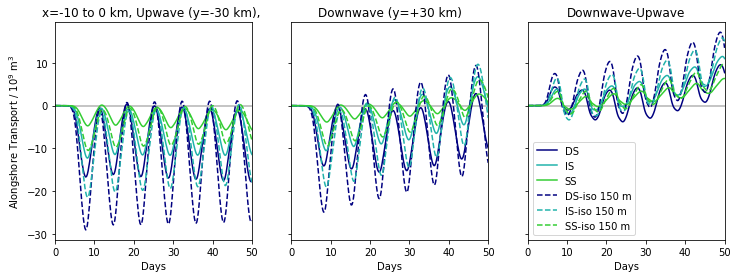

In [8]:
labels = ['DS','IS','SS','DS-iso 150 m','IS-iso 150 m','SS-iso 150 m']
colors = ['navy','lightseagreen','limegreen','navy','lightseagreen','limegreen']
lines = ['-','-','-','--','--','--']

transports1 = [int_trans_DS_upw, int_trans_IS_upw, int_trans_SS_upw,
               int_trans_DS_upw2, int_trans_IS_upw2, int_trans_SS_upw2]
transports2 = [int_trans_DS_dnw, int_trans_IS_dnw, int_trans_SS_dnw,
               int_trans_DS_dnw2, int_trans_IS_dnw2, int_trans_SS_dnw2]

fig, (ax1,ax2,ax3) = plt.subplots(1,3,figsize=(12,4), sharey=True, sharex=True)
for ax in (ax1,ax2,ax3):
    ax.axhline(0,color='0.7')
    ax.set_xlabel('Days')

for col, lab, line, int_trans1, int_trans2 in zip(colors, labels, lines, transports1, transports2):
    ax1.plot(ds.ocean_time/(3600*24),int_trans1/1E9,color=col, label=lab, linestyle=line)
    ax2.plot(ds.ocean_time/(3600*24),int_trans2/1E9,color=col, label=lab, linestyle=line)
    ax3.plot(ds.ocean_time/(3600*24),(int_trans2-int_trans1)/1E9,color=col, label=lab, linestyle=line)

ax1.set_title('x=-10 to 0 km, Upwave (y=-30 km), ')
ax2.set_title('Downwave (y=+30 km)')
ax3.set_title('Downwave-Upwave')
ax1.set_ylabel('Alongshore Transport / $10^9$ m$^3$')
ax1.set_xlim(0,50)
ax3.legend()

In [9]:
# Where's the 150 m isobath in x?

ds.h[10,239-36]

<xarray.DataArray 'h' ()>
array(148.201242)
Coordinates:
    x_rho    float64 ...
    y_rho    float64 ...
Attributes:
    long_name:  bathymetry at RHO-points
    units:      meter
    grid:       grid
    location:   face
    field:      bath, scalar

### Cross shelf transport 

**Integrated CS transport in Fig 4**

In [10]:
int_transCS_DS = np.zeros_like(ds.ocean_time[:])
int_transCS_IS = np.zeros_like(ds.ocean_time[:])
int_transCS_SS = np.zeros_like(ds.ocean_time[:])

transports1 = [int_transCS_DS, int_transCS_IS, int_transCS_SS]

for file, int_trans1 in zip(files, transports1):
    
    ds = xr.open_dataset(file, decode_times=False)
    trans1 = CS_transport(ds, x1, y1, y2)
    
    ## integrated transport
    int_trans1[0] = trans1[0]
    
    for tt in range(1,len(ds.ocean_time)):
        int_trans1[tt] = np.sum(trans1[0:tt+1]*dt)

In [12]:
int_transCS_DS2 = np.zeros_like(ds.ocean_time[:])
int_transCS_IS2 = np.zeros_like(ds.ocean_time[:])
int_transCS_SS2 = np.zeros_like(ds.ocean_time[:])

transports1 = [int_transCS_DS2, int_transCS_IS2, int_transCS_SS2]
x_array = [x1_DS, x1_IS, x1_SS]

for file, int_trans1, x_iso in zip(files, transports1, x_array):
    
    ds = xr.open_dataset(file, decode_times=False)
    trans1 = CS_transport(ds, x_iso, y1, y2)
    
    ## integrated transport
    int_trans1[0] = trans1[0]
    
    for tt in range(1,len(ds.ocean_time)):
        int_trans1[tt] = np.sum(trans1[0:tt+1]*dt)

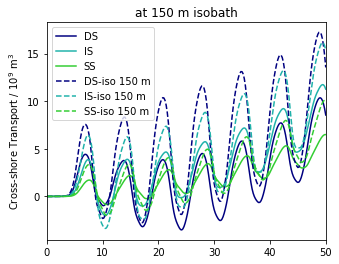

In [14]:
labels = ['DS','IS','SS','DS-iso 150 m','IS-iso 150 m','SS-iso 150 m']
colors = ['navy','lightseagreen','limegreen','navy','lightseagreen','limegreen']
lines = ['-','-','-','--','--','--']

transports1 = [int_transCS_DS, int_transCS_IS, int_transCS_SS,
               int_transCS_DS2, int_transCS_IS2, int_transCS_SS2]

fig, (ax2) = plt.subplots(1,1,figsize=(5,4), sharey=True, sharex=True)

for col, lab, line, int_trans1 in zip(colors, labels, lines, transports1):
    ax2.plot(ds.ocean_time/(3600*24),int_trans1/1E9,color=col, label=lab, linestyle=line)
ax2.set_title('at 150 m isobath')
ax2.set_ylabel('Cross-shore Transport / $10^9$ m$^3$')
ax2.set_xlim(0,50)
ax2.legend()

In [15]:
# Saving the objects:
with open('cs_integrated_transport.pkl', 'wb') as f:  # Python 3: open(..., 'wb')
    pickle.dump([int_transCS_DS2,int_transCS_IS2,int_transCS_SS2,ds.ocean_time/(3600*24)], f)

### Plot transport cross-sections

In [16]:
nt1 = 90
nt2 = 195
x_isos = [x1_DS, x1_IS, x1_SS]

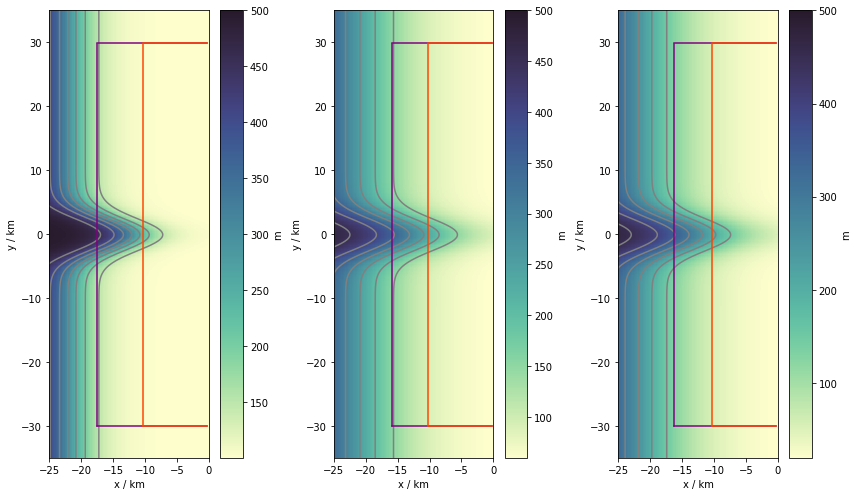

In [17]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3,figsize=(12,7))

for file, ax, x_iso in zip(files, [ax1,ax2,ax3], x_isos):
    with Dataset(file, 'r') as nbl:
        h = nbl.variables['h'][:]
        x_rho = nbl.variables['x_rho'][:]
        y_rho = nbl.variables['y_rho'][:]
    pc1 = ax.pcolormesh(x_rho/1E3-400,y_rho/1E3-400,h, cmap=cmo.cm.deep)
    cf1 = ax.contour(x_rho/1E3-400,y_rho/1E3-400,h,levels=[150,200,250,300,350,400,450,500], colors='0.5')
    cb1 = plt.colorbar(pc1,ax=ax)
    cb1.set_label('m')

    ax.plot(x_rho[y1,x_iso:x2]/1000-400,y_rho[y1,x_iso:x2]/1000-400, color='purple')
    ax.plot(x_rho[y2,x_iso:x2]/1000-400,y_rho[y2,x_iso:x2]/1000-400, color='purple')
    ax.plot(x_rho[y1:y2,x_iso]/1000-400,y_rho[y1:y2,x_iso]/1000-400, color='purple')
    ax.plot(x_rho[y1,x1:x2]/1000-400,y_rho[y1,x1:x2]/1000-400, color='orangered')
    ax.plot(x_rho[y2,x1:x2]/1000-400,y_rho[y2,x1:x2]/1000-400, color='orangered')
    ax.plot(x_rho[y1:y2,x1]/1000-400,y_rho[y1:y2,x1]/1000-400, color='orangered')

    ax.set_aspect(1)

    ax.set_ylim(-35,35)
    ax.set_xlim(-25,0)
    ax.set_xlabel('x / km')
    ax.set_ylabel('y / km')
    plt.tight_layout()

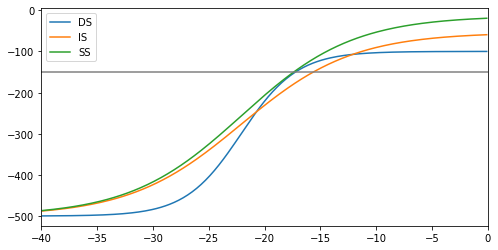

In [18]:
fig, (ax1) = plt.subplots(1,1,figsize=(8,4))

for file, x_iso, lab in zip(files, x_isos, labels):
    with Dataset(file, 'r') as nbl:
        h = nbl.variables['h'][:]
        x_rho = nbl.variables['x_rho'][:]
        y_rho = nbl.variables['y_rho'][:]
    pc1 = ax1.plot(x_rho[1,90:]/1E3-400,-h[1,90:], label=lab)

ax1.axhline(-150, color='0.5')   
ax1.set_xlim(-40,0)
ax1.legend()